In [84]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.tsa.arima_model import ARMAResults 

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
from statsmodels.tsa.seasonal import seasonal_decompose
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats
import numpy.linalg
from scipy.stats import spearmanr,pearsonr, kstest,shapiro, anderson, normaltest
import itertools


In [2]:
!pip install plotly

Забираем данные из файла и сортируем по дате. 

In [205]:
master_data=pd.read_csv('Bitcoin_Historical_Price.csv')
master_data.sort_values(by='Date',ascending = False)
master_data.head()
# df = pd.read_csv('Bitcoin_Historical_Price.csv',parse_dates=['Date'])
# df = df.set_index('Date')
# data =df.iloc[1300:,]
# data.asfreq('W').head() 

,Date,Close
0,01-08-2017,2710.67
1,02-08-2017,2804.73
2,03-08-2017,2895.89
3,04-08-2017,3252.91
4,05-08-2017,3213.94


In [192]:
data.describe()

,Close
count,1772.000000
mean,1547.358307
std,3042.572674
min,68.430000
25%,275.995000
50%,490.415000
75%,893.650000
max,19497.400000


Построим график временного ряда

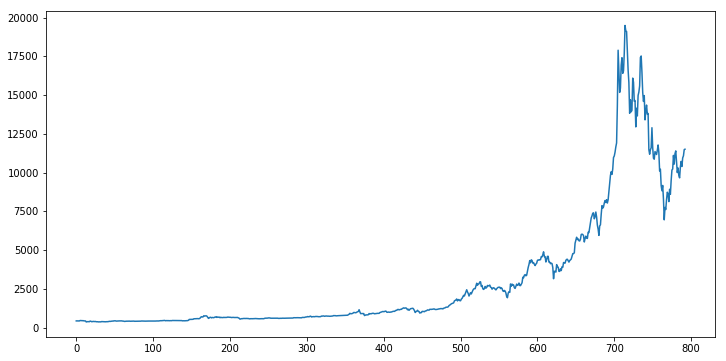

In [193]:
# data_30 = pd.Series(master_data)
master_data.Close.plot(figsize=(12,6))


ACF and PACF 

Критерий Дики-Фуллера: p=0.845284
Критическое значение {'1%': -3.4388489336836003, '5%': -2.865291103159288, '10%': -2.568767459327767}


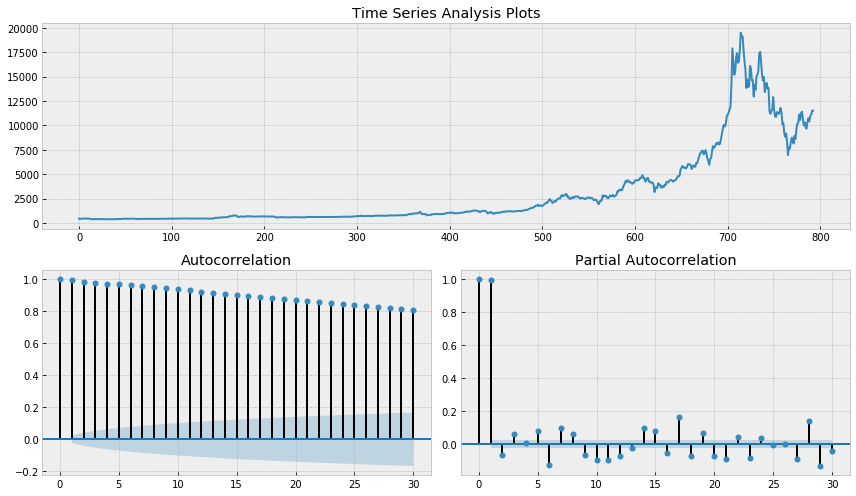

In [194]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        print("Критическое значение",sm.tsa.stattools.adfuller(y)[4])

        plt.tight_layout()
    return 

tsplot(master_data.Close, lags=30)

Получили стационарный ряд

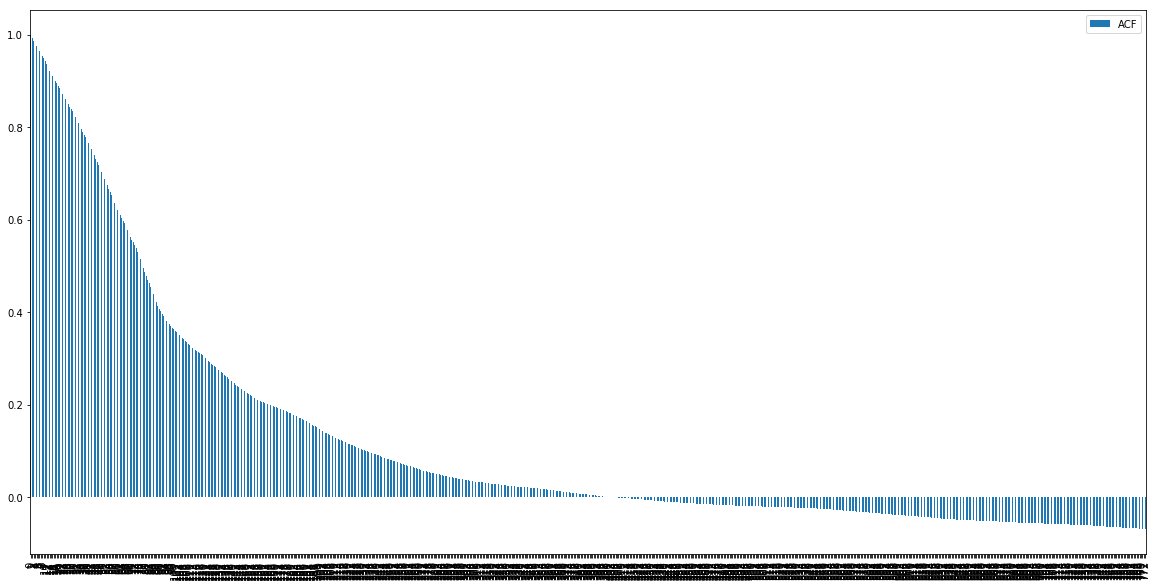

In [158]:
acf_plot = pd.DataFrame(acf(master_data['Close'], nlags=772))
acf_plot.columns=['ACF']
acf_plot.plot(kind='bar',figsize=(20,10))

,Close
count,215.000000
mean,8512.205395
std,4371.927870
min,2710.670000
25%,4379.645000
50%,7621.300000
75%,11341.300000
max,19497.400000


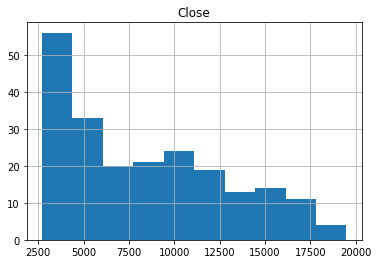

In [206]:
itog = master_data.describe()
master_data.hist()
itog

In [195]:
otg1diff = (master_data.set_index('Date')).diff(periods=1).dropna()
# print(otg1diff)
test = sm.tsa.adfuller(otg1diff.Close)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.99255929471437
p-value:  0.0014499780518931053
Critical values:  {'1%': -3.4388710830827125, '5%': -2.8653008652386576, '10%': -2.568772659807725}
единичных корней нет, ряд стационарен


In [196]:
otg2diff = (master_data.set_index('Date')).diff(periods=2).dropna()
# print(otg1diff)
test = sm.tsa.adfuller(otg2diff.Close)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.153929749315009
p-value:  0.0007877447457831102
Critical values:  {'1%': -3.438882201132452, '5%': -2.865305765357574, '10%': -2.568775270215655}
единичных корней нет, ряд стационарен


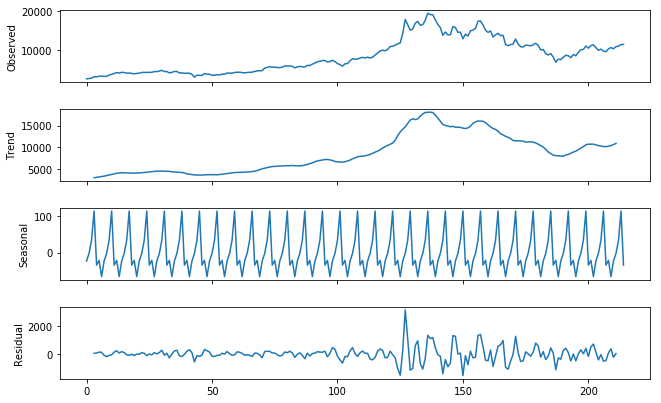

In [223]:
result = sm.tsa.seasonal_decompose(master_data.Close,model='additive',freq=7)
fig = result.plot()
fig.set_size_inches(10, 6)
plt.show()

так как ряд стационарный то d = 0
построим все комбинации параметров


In [252]:
# Define the p, d and q parameters to take any value between 0 and 2
p  = q = range(0, 2)
d = (0,0)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
for param in pdq:
    mod = sm.tsa.ARIMA(master_data.Close, order=param)
    results = mod.fit()
    print('ARIMA _aic ',ARMAResults.aic(results), param)


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 0, 0, 7)
SARIMAX: (0, 0, 0) x (0, 0, 1, 7)
SARIMAX: (0, 0, 0) x (1, 0, 0, 7)
ARIMA _aic  4217.813757342003 (0, 0, 0)
ARIMA _aic  3955.732301619738 (0, 0, 1)
ARIMA _aic  4217.813757342003 (0, 0, 0)
ARIMA _aic  3955.732301619738 (0, 0, 1)
ARIMA _aic  3410.1836816195896 (1, 0, 0)
ARIMA _aic  3409.7095065894314 (1, 0, 1)
ARIMA _aic  3410.1836816195896 (1, 0, 0)
ARIMA _aic  3409.7095065894314 (1, 0, 1)


ARIMA _aic  3409.7095065894314 (1, 0, 1)

In [274]:
model = sm.tsa.ARIMA(master_data.Close, order=(1,0,1)).fit()
# model = sm.tsa.ARIMA(rolling_mean.fillna(rolling_mean.mean()), order=(1,1,1)).fit()
print (model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  215
Model:                     ARMA(1, 1)   Log Likelihood               -1700.855
Method:                       css-mle   S.D. of innovations            653.992
Date:                Thu, 23 May 2019   AIC                           3409.710
Time:                        01:28:46   BIC                           3423.192
Sample:                             0   HQIC                          3415.157
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7912.6042   2827.795      2.798      0.006    2370.227    1.35e+04
ar.L1.Close     0.9863      0.010     98.621      0.000       0.967       1.006
ma.L1.Close     0.1155      0.073      1.583    

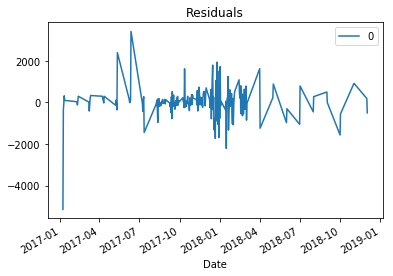

In [273]:
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.plots(1,2)
fig  = residuals.plot(title="Residuals")
# residuals.plot(kind='kde', title='Density', ax=ax[1],figsize=(20, 10))
plt.show()

In [264]:
from scipy.stats import spearmanr,pearsonr, kstest,shapiro, anderson, normaltest
est2=model
result = anderson(model_fit.resid)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
stat, p = normaltest(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
stat, p = shapiro(model_fit.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
kstest(residuals, 'norm')


Statistic: 9.099
15.000: 0.566, data does not look normal (reject H0)
10.000: 0.644, data does not look normal (reject H0)
5.000: 0.773, data does not look normal (reject H0)
2.500: 0.902, data does not look normal (reject H0)
1.000: 1.073, data does not look normal (reject H0)
Statistics=88.747, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.830, p=0.000
Sample does not look Gaussian (reject H0)


KstestResult(statistic=1.0, pvalue=0.0)

In [265]:
print('durbin_watson',durbin_watson(est2.resid))
print('nlag=2',acorr_breusch_godfrey(est2, nlags=2))
print('nlag=3',acorr_breusch_godfrey(est2, nlags=3))
print('nlag=4',acorr_breusch_godfrey(est2, nlags=4))

durbin_watson 1.7864406225315803
nlag=2 (0.4316761884673814, 0.8058657656261039, 0.2132545716196142, 0.8081235349698184)
nlag=3 (0.45593047014538424, 0.928460957791888, 0.14946630687010007, 0.929947980740195)
nlag=4 (1.2813934994563614, 0.8645243992487092, 0.3147744589158443, 0.8679066781709915)


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6    3096.717143
7    3186.974286
8    3269.338571
9    3377.157143
Name: Close, dtype: float64


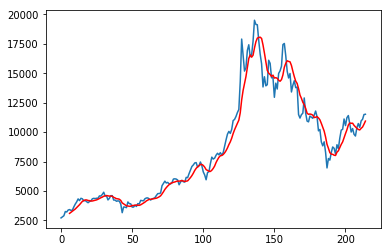

In [268]:
series =master_data.Close
rolling = master_data.Close.rolling(window=7)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
pyplot.show()

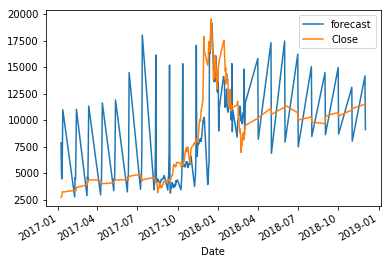

In [259]:
model_fit.plot_predict(dynamic=False)
plt.show()

204 204 215
10


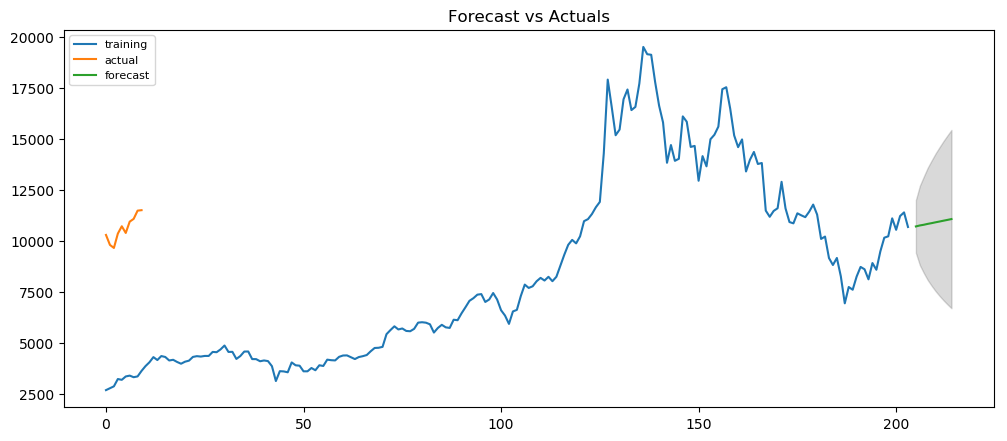

In [230]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
u = int(len(master_data)*0.95)
print(u,int(len(master_data)*0.95), len(master_data))
train = master_data[:u]
test = master_data[u+1:]
print(len(test))
model = ARIMA(train.Close.values, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(int(len(master_data)*0.05), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.Close.values, label='training')
plt.plot(test.Close.values, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [275]:
# Define the p, d and q parameters to take any value between 0 and 2
p  = q = range(0, 2)
d = (0,0)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(master_data.Close,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 0, 0, 7)
SARIMAX: (0, 0, 0) x (0, 0, 1, 7)
SARIMAX: (0, 0, 0) x (1, 0, 0, 7)
ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:4533.200223543177
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:4255.8783327734445
ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:4533.200223543177
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:4255.8783327734445
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:3714.3497955183475
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:3694.6166925283223
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:3714.3497955183475
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:3694.6166925283223
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:4359.39356736811
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:4186.191335885283
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:4359.39356736811
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:4186.191335885283
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:3547.489016653397
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:3516.9689977863545
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:3547.489016653397
ARIMA(0

ARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:3272.57621686961

In [277]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())


                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                  215
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1631.288
Date:                           Thu, 23 May 2019   AIC                           3272.576
Time:                                   01:33:15   BIC                           3289.216
Sample:                                        0   HQIC                          3279.306
                                           - 215                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0008      0.003    296.204      0.000       0.994       1.007
ma.L1          0.1066      0.044      2.444

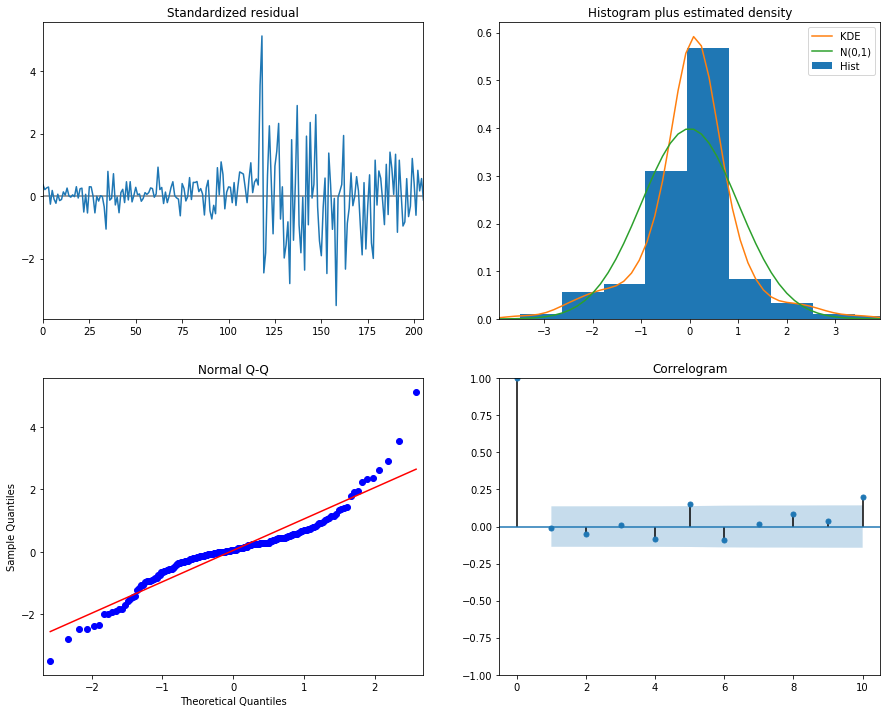

In [278]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [76]:
pred = results.get_prediction(start=0, dynamic=False)
pred_ci = pred.conf_int()

In [48]:
pred_dynamic = results.get_prediction(start=1, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()